# Time-Series Forecasting | Corporación Favorita Grocery Sales
## Section 1: Data Preparation
### 1 - Notebook Overview

The raw `train.csv` file (~5GB) from the **Corporación Favorita** dataset is too large to load directly into memory for standard exploratory analysis. This notebook implements a memory-efficient preprocessing pipeline using **Pandas chunking** to create a lightweight, analysis‑ready subset by:

- **Regional Filtering:** Isolating the `Guayas` region to focus the analysis.
- **Product Specialization:** Trimming the dataset to the `top three product families` (by unique item count) to reduce SKU-level complexity while maintaining high-volume signals.
- **Streamed Sampling:** Extracting `300,000 rows` using a chunk-based ingestion strategy to optimize workflow.
- **Boolean Standardization:** Cleaning the `onpromotion` column for consistent logical processing.
- **Integrity Checks:** Identifying and handling missing values in the `train` dataset.
- **Outlier Validation:** Evaluating high-sales peaks identified via z-scores to decide if they represent true market signals or noise.
- **Temporal Alignment:** Reconstructing the full daily time index by filling missing dates with zero sales to ensure a continuous timeline.
- **Optimized Persistence:** Saving the final prepared dataset as a `Parquet` file for near-instant loading in subsequent notebooks.

This preprocessing stage ensures a clean, reliable foundation for modeling. The prepared dataset is then utilized in [Section 2: Exploratory Data Analysis](/notebooks/02-exploratory-data-analysis.ipynb).

---

### 2 - Import Libraries

In [1]:
# Core libraries
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt

# File handling
import os

# Dismiss deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### 3 - Data Ingestion

In [2]:
# Define Local Paths
items_path = "../data/items.csv"
stores_path = "../data/stores.csv"
train_path = "../data/train.csv"

# Verify files exist before starting any processing
if not os.path.exists(items_path) or not os.path.exists(stores_path) or not os.path.exists(train_path):
    print("❌ ERROR: Required data files not found in the /data/ folder.")
    print("-" * 50)
    print("To run this notebook, please download the dataset from Kaggle:")
    print("https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting")
    print("\nEnsure 'items.csv' 'stores.csv' and 'train.csv' are placed in your './data/' directory.")
    print("-" * 50)
else:
    print("✅ Local files detected. Starting chunked ingestion...")

✅ Local files detected. Starting chunked ingestion...


In [3]:
# Read items and stores data
df_items = pd.read_csv(items_path)
df_stores = pd.read_csv(stores_path)

# Filter stores from the Guayas Region only
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Read train.csv in chunks 1 million rows at a time to prevent memory overload
chunk_size = 10**6
filtered_chunks = []

for chunk in pd.read_csv(train_path, chunksize=chunk_size, dtype={'onpromotion': object}):
    # map handles the strings, .astype("boolean") supports nulls if they exist
    chunk['onpromotion'] = chunk['onpromotion'].map({'True': True, 'False': False, None: None}).astype('boolean')

    # Filter rows belonging to Pichincha region
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    filtered_chunks.append(chunk_filtered)

    # Free up memory before reading next chunk
    del chunk

# Combine all filtered chunks
df_train = pd.concat(filtered_chunks, ignore_index=True)

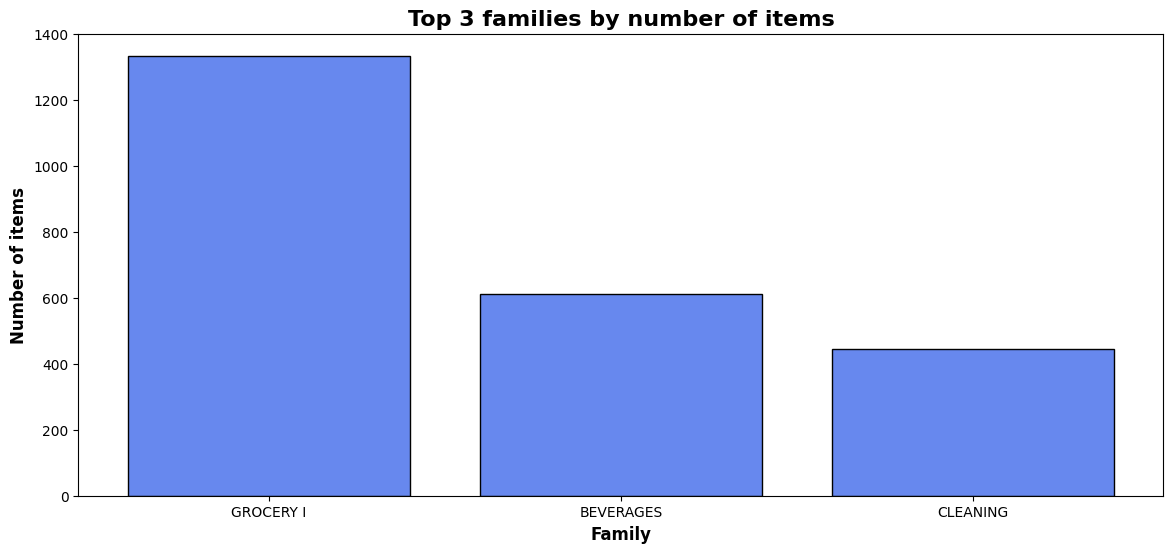

In [4]:
# Identify the top-3 families by item count
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)

# Visualize the three families with the largest number of items
plt.figure(figsize=(14, 6))
plt.bar(top_3_families['Family'],
        top_3_families['Item Count'],
        color='#6788ee',
        edgecolor='black')

plt.title("Top 3 families by number of items", fontsize=16, fontweight='bold')
plt.xlabel("Family", fontsize=12, fontweight='bold')
plt.ylabel("Number of items", fontsize=12, fontweight='bold')
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10, rotation=0)

# Save the visualization
plt.savefig('../visualizations/guayas-top-3-families.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [5]:
# Get list of item_nbrs that belong to those families
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()

# Filter the training data
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

# Inspect the result
print(f"\n---DATASET SHAPE---\nRows: {df_train.shape[0]}\nColumns: {df_train.shape[1]}")
display(df_train.head())


---DATASET SHAPE---
Rows: 14745768
Columns: 6


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.0,<NA>
2,18791,2013-01-02,24,105575,2.0,<NA>
3,18792,2013-01-02,24,105577,1.0,<NA>
4,18793,2013-01-02,24,105693,7.0,<NA>
5,18794,2013-01-02,24,105737,17.0,<NA>


In [6]:
# Randomly sample 300,000 rows in a reproducible way
sample_size = min(300_000, len(df_train))
df_train = (
    df_train
    .sample(n=sample_size, random_state=42)
    .reset_index(drop=True)
)

# Cleanup memory
del filtered_chunks

# Inspect the result
print(f"\n---DATASET SHAPE---\nRows: {df_train.shape[0]}\nColumns: {df_train.shape[1]}")
display(df_train.head())


---DATASET SHAPE---
Rows: 300000
Columns: 6


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,86626618,2016-07-31,32,1395693,1.0,False
1,53995064,2015-08-15,24,1464210,30.0,False
2,21834951,2014-04-04,27,1102970,1.0,False
3,14853390,2013-12-02,26,1162382,20.0,<NA>
4,14652646,2013-11-28,34,577741,2.0,<NA>


### 4 - Missing Data

In [7]:
# Checking missing values
df_train.isnull().sum()

id                 0
date               0
store_nbr          0
item_nbr           0
unit_sales         0
onpromotion    55706
dtype: int64

Since promotions are relatively uncommon in this dataset, the missing values in the `onpromotion` column likely indicate non‑promoted items rather than true gaps in the data. To preserve consistency, I’ll replace these **NaN** values with **False** before continuing.

In [8]:
# Replacing missing values in the 'onpromotion' column
df_train['onpromotion'] = (
    df_train['onpromotion']
    .astype('boolean')
    .fillna(False)
)

# Rechecking missing values
df_train.isnull().sum()

id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64

### 5 - Data Integrity & Returns

To begin addressing outliers, I first look for negative sales values, since these represent product returns and need to be handled before any meaningful analysis can continue.

In [9]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]
print(f"Number of negative sales: {len(negative_sales)}\n")

if not negative_sales.empty:
    display(negative_sales.head())

Number of negative sales: 13



,id,date,store_nbr,item_nbr,unit_sales,onpromotion
52366,57419947,2015-09-24,29,1463484,-5.0,False
101347,71021589,2016-02-19,27,472314,-1.0,False
108742,309805,2013-01-09,35,1079215,-8.0,False
112649,113492918,2017-04-24,35,305344,-2.0,False
126777,24310381,2014-05-24,36,155625,-2.0,False


Since negative sales values correspond to product returns rather than true sales demand, I’ll convert these entries to zero so the dataset reflects actual sales for forecasting purposes.

In [10]:
# Replacing negative sales with 0 using .clip() for better performance
df_train['unit_sales'] = df_train['unit_sales'].clip(lower=0)

# Confirm all negative sales were replaced
remaining_negatives = (df_train['unit_sales'] < 0).sum()
print(f"Negative sales remaining: {remaining_negatives}")

Negative sales remaining: 0


### 6 - Handling Outliers

It is essential to account for unusually high sales spikes that may not reflect normal demand patterns. These extreme observations can arise from promotions, special events, or simple data inconsistencies, and they can distort both exploratory analysis and forecasting models if left untreated. To flag these anomalies, I’ll examine the distribution of sales and use **Z‑scores** to identify values that sit far outside the typical range for each store or item.

In [11]:
# Group by store_nbr and item_nbr to calculate mean and std dev
group_stats = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales']

# Compute mean and standard deviation for each store-item group
mean_sales = group_stats.transform('mean')
std_sales = group_stats.transform('std')

# Calculate Z-score for unit_sales and handle division by zero
z_scores = (df_train['unit_sales'] - mean_sales) / std_sales.replace(0, 1)

# Define threshold for outliers and filter
df_outliers = df_train[z_scores > 5].copy()
df_outliers['z_score'] = z_scores[z_scores > 5]

# Print summary
print(f"Total rows: {len(df_train)}")
print(f"Number of outliers detected: {len(df_outliers)}")
print(f"Percentage of data flagged: {(len(df_outliers) / len(df_train)) * 100:.2f}%")
display(df_outliers.head())

Total rows: 300000
Number of outliers detected: 68
Percentage of data flagged: 0.02%


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
4323,123541734,2017-07-28,27,933780,22.0,True,5.023884
9812,13913825,2013-11-13,24,315277,102.0,False,5.073205
14884,77056692,2016-04-22,36,169028,52.0,False,5.228116
24806,76869154,2016-04-20,36,1074327,274.0,False,5.393242
25186,124870225,2017-08-09,51,1091367,131.0,True,5.268908


Overall, the outlier analysis shows that only a very small fraction (~0.02%) of the dataset exhibits unusually high sales values. These spikes are not necessarily errors and may reflect genuine demand surges. Since the goal at this stage is to understand the data rather than aggressively clean it, I’m keeping these observations in the dataset. In a real forecasting workflow, decisions about handling extreme values would depend on domain knowledge and the model’s sensitivity to rare events. For now, identifying them is enough to stay aware of potential anomalies without prematurely removing information that could be meaningful for future modeling.

### 7 - Filling Missing Dates with Zeros

Before building any time‑series features, the dataset needs a complete and continuous calendar. If a product in a store is missing certain dates, the model can’t tell whether those gaps represent _no sales_ or _missing data_. To avoid misinterpretation and ensure stable feature engineering, we explicitly fill all missing dates with 0 sales. This step is essential because it:

- **Keeps the time axis consistent:** Time‑series models assume evenly spaced observations. Missing days break that structure.
- **Preserves true demand signals:** A zero is meaningful and should not be silently dropped.
- **Prevents misalignment in lag and rolling features:** Sliding windows rely on a complete calendar. Gaps shift values and distort patterns.
- **Improves model reliability:** A fully populated timeline gives the model a clearer, more accurate view of historical behavior.

With that foundation in place, the next step is to generate a complete daily calendar for every (`store_nbr`, `item_nbr`) pair and fill any missing dates with `unit_sales = 0`.

In [12]:
# Ensure date is a proper datetime type
df_train['date'] = pd.to_datetime(df_train['date'])

# Preview train
print("Before filling in missing calendar dates:\n")
display(df_train.head())

# Convert onpromotion to numpy bool for compatibility with asfreq()
df_train['onpromotion'] = df_train['onpromotion'].astype(bool)

# Function to fill in missing calendar days for each store–item pair
def fill_calendar(group):
    # One (store_nbr, item_nbr) group at a time
    g = group.set_index("date").sort_index()  # Use date as index
    g = g.asfreq("D", fill_value=0)  # Full daily calendar with 0 where missing

    # Restore identifiers dropped by asfreq()
    g["store_nbr"] = group["store_nbr"].iloc[0]
    g["item_nbr"]  = group["item_nbr"].iloc[0]

    return g.reset_index()  # Bring date back as a normal column

# Apply the calendar-filling step to every store–item pair
df_train = (
    df_train
    .groupby(["store_nbr", "item_nbr"], group_keys=False)
    .apply(fill_calendar)
)

# Preview train
print("\nAfter filling in missing calendar dates:\n")
display(df_train.head())

Before filling in missing calendar dates:



,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,86626618,2016-07-31,32,1395693,1.0,False
1,53995064,2015-08-15,24,1464210,30.0,False
2,21834951,2014-04-04,27,1102970,1.0,False
3,14853390,2013-12-02,26,1162382,20.0,False
4,14652646,2013-11-28,34,577741,2.0,False



After filling in missing calendar dates:



,date,id,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-06-08,6679651,24,96995,2.0,False
1,2013-06-09,0,24,96995,0.0,0
2,2013-06-10,0,24,96995,0.0,0
3,2013-06-11,0,24,96995,0.0,0
4,2013-06-12,0,24,96995,0.0,0


In [13]:
# Inspect the result
print(f"\n---DATASET SHAPE---\nRows: {df_train.shape[0]}\nColumns: {df_train.shape[1]}")


---DATASET SHAPE---
Rows: 19239582
Columns: 6


### 8 - Export Cleaned Dataset

In [14]:
# Confirmed cleaned column names and data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19239582 entries, 0 to 0
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   id           int64         
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   unit_sales   float64       
 5   onpromotion  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.0+ GB


In [15]:
# Export to Pickle
output_path = "../data/train_sample.pkl"

print(f"Saving {len(df_train):,} rows to Pickle...")
df_train.to_pickle(output_path) 

print(f"\n✅ Success! Data safely pickled at: {output_path}")

Saving 19,239,582 rows to Pickle...

✅ Success! Data safely pickled at: ../data/train_sample.pkl
